In [1]:
# %matplotlib inline
import random
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import torch
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt

# Set random seed for reproducibility
manualSeed = 12
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  # Needed for reproducible results

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

Random Seed:  12


In [2]:
# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 128

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
from torch.utils.data import ConcatDataset

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.Flowers102(
    root='./data', split='test', transform=transform, download=True)
testset = torchvision.datasets.Flowers102(
    root='./data', split='train', transform=transform, download=True)
validdataset = torchvision.datasets.Flowers102(
    root='./data', split='val', transform=transform, download=True)
dataset = ConcatDataset([trainset, testset, validdataset])

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

print("訓練集樣本數量:", len(dataset))

訓練集樣本數量: 8189


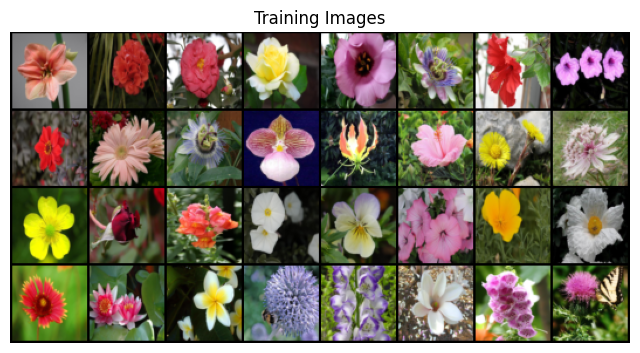

In [4]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (
    torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[
           :64], padding=2, normalize=True).cpu(), (1, 2, 0)))

## Initialize parameters of Generator and Discriminator
This step for initializing the parameters of the generator and discriminator.
And define the structure of the dcGAN.

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class ResidualBlock(nn.Module):
    """Residual block with Conv-BatchNorm-ReLU structure."""

    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.ConvTranspose2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)


class Generator(nn.Module):
    def __init__(self, ngpu):
        """
        Stronger Generator for GAN
        :param ngpu: Number of GPUs
        :param nz: Size of the latent vector
        :param ngf: Feature size multiplier
        :param nc: Number of image channels
        """
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.init_layer = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4,
                               stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True)
        )

        self.res_block1 = ResidualBlock(ngf * 8, ngf * 8)
        self.upconv1 = nn.ConvTranspose2d(
            ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 4)

        self.res_block2 = ResidualBlock(ngf * 4, ngf * 4)
        self.upconv2 = nn.ConvTranspose2d(
            ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 2)

        self.res_block3 = ResidualBlock(ngf * 2, ngf * 2)
        self.upconv3 = nn.ConvTranspose2d(
            ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf)

        self.res_block4 = ResidualBlock(ngf, ngf)
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        x = self.init_layer(input)
        x = self.res_block1(x)
        x = self.bn1(self.upconv1(x))
        x = self.res_block2(x)
        x = self.bn2(self.upconv2(x))
        x = self.res_block3(x)
        x = self.bn3(self.upconv3(x))
        x = self.res_block4(x)
        return self.final_layer(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (init_layer): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res_block1): ResidualBlock(
    (conv1): ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upconv1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_block2): ResidualBlock(
    (conv1): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1

In [9]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.5*lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training Step

In [10]:
# Training Loop
import torchvision.transforms as T
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
lambda_r1 = 10  # Define the R1 gradient penalty coefficient
# masked_real_cpu = add_random_mask(real_cpu.clone())
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        real_labels = torch.ones(b_size, device=device) * real_label
        fake_labels = torch.zeros(b_size, device=device) * fake_label

        # Train with real data
        real_images = real_cpu.requires_grad_(True)
        real_output = netD(real_images).view(-1)
        errD_real = criterion(real_output, real_labels)
        D_x = real_output.mean().item()

        # Compute R1 penalty
        real_gradients = torch.autograd.grad(
            outputs=real_output.sum(),
            inputs=real_images,
            create_graph=True
        )[0]
        r1_penalty = torch.mean(real_gradients.view(
            real_gradients.size(0), -1).norm(2, dim=1) ** 2)

        # Train with fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        fake_output = netD(fake.detach()).view(-1)
        errD_fake = criterion(fake_output, fake_labels)
        D_G_z1 = fake_output.mean().item()

        # Discriminator loss
        errD = errD_real + errD_fake + lambda_r1 * r1_penalty
        errD.backward()
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        fake_output = netD(fake).view(-1)
        errG = criterion(fake_output, real_labels)
        errG.backward()
        optimizerG.step()

        # Save losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Print stats
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\t'
                  f'Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t'
                  f'D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}')

        # Save images and checkpoints
        if iters % 500 == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/30][0/256]	Loss_D: 10.9913	Loss_G: 0.4578	D(x): 0.7334	D(G(z)): 0.7288
[0/30][50/256]	Loss_D: 101.7007	Loss_G: 10.0000	D(x): 0.9863	D(G(z)): 1.0000
[0/30][100/256]	Loss_D: 12.2276	Loss_G: 24.8279	D(x): 0.2220	D(G(z)): 0.9947
[0/30][150/256]	Loss_D: 5.4436	Loss_G: 2.9296	D(x): 0.3923	D(G(z)): 0.9659
[0/30][200/256]	Loss_D: 3.2338	Loss_G: 1.6014	D(x): 0.2312	D(G(z)): 0.6844
[0/30][250/256]	Loss_D: 1.8089	Loss_G: 1.1685	D(x): 0.3619	D(G(z)): 0.4310
[1/30][0/256]	Loss_D: 2.7999	Loss_G: 0.8132	D(x): 0.3228	D(G(z)): 0.6497
[1/30][50/256]	Loss_D: 2.0192	Loss_G: 1.2443	D(x): 0.3882	D(G(z)): 0.5220
[1/30][100/256]	Loss_D: 1.9185	Loss_G: 1.9865	D(x): 0.5023	D(G(z)): 0.6181
[1/30][150/256]	Loss_D: 1.0945	Loss_G: 1.5407	D(x): 0.6272	D(G(z)): 0.3267
[1/30][200/256]	Loss_D: 1.5888	Loss_G: 1.3055	D(x): 0.4783	D(G(z)): 0.4174
[1/30][250/256]	Loss_D: 1.4466	Loss_G: 1.0688	D(x): 0.5194	D(G(z)): 0.4420
[2/30][0/256]	Loss_D: 1.6194	Loss_G: 0.9499	D(x): 0.4072	D(G(z)): 0.4561
[

In [11]:
import os
import torch

# Ensure the folder exists
model_weights_folder = './model_weights'
os.makedirs(model_weights_folder, exist_ok=True)

# Save Generator weights
generator_weights_path = os.path.join(model_weights_folder, 'generator.pth')
torch.save(netG.state_dict(), generator_weights_path)
print(f"Generator weights saved to {generator_weights_path}")

# Save Discriminator weights
discriminator_weights_path = os.path.join(
    model_weights_folder, 'discriminator.pth')
torch.save(netD.state_dict(), discriminator_weights_path)
print(f"Discriminator weights saved to {discriminator_weights_path}")

Generator weights saved to ./model_weights/generator.pth
Discriminator weights saved to ./model_weights/discriminator.pth


## Create fake dataset for calculating FID scores
FID scores use to evaluate the similarity between two datasets.

In [12]:
import torch
import torchvision.transforms as T

torch.cuda.empty_cache()  # Clear any unused memory on the GPU

# Total noise for all images
noise = torch.randn(8189, nz, 1, 1, device=device)

# Directory to save images
output_dir = './GENIMG/'

# Generate and save images in chunks
for i in range(0, noise.size(0), batch_size):
    batch_noise = noise[i:i + batch_size]  # Take a smaller chunk of noise
    fake_images = netG(batch_noise)  # Generate images for this chunk

    for j, fake_image in enumerate(fake_images):
        transform = T.ToPILImage()
        img = transform(fake_image.cpu())  # Convert tensor to PIL image
        img.save(f'{output_dir}/fake_{i + j}.jpg')  # Save image
    del batch_noise
    del fake_images
    torch.cuda.empty_cache()

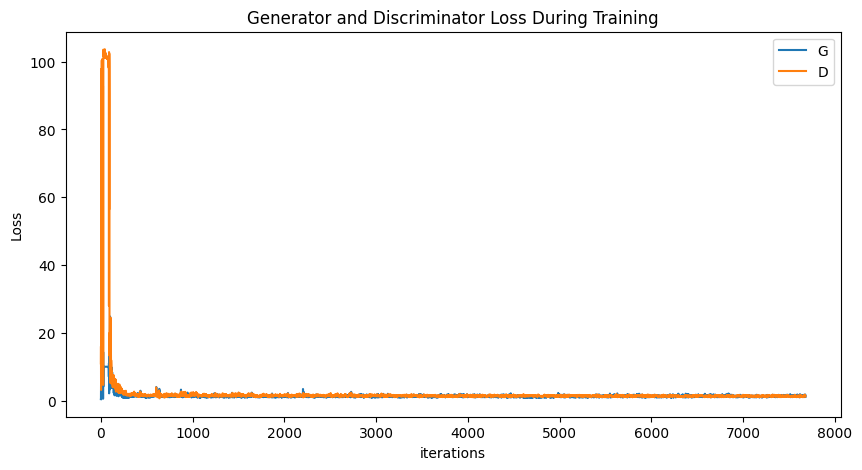

In [13]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from pytorch_fid import fid_score
from PIL import Image
import os

# The path of original dataset resized into 64x64 pixels.
resized_folder_path = './resized/'
# The path of generated dataset.
generated_images_folder = './GENIMG/'
# Use Model Inception V3 to calculate FID score. (Inception V3 is a pre-trained model)
inception_model = torchvision.models.inception_v3(pretrained=True)
fid_value = fid_score.calculate_fid_given_paths(
    [resized_folder_path, generated_images_folder], batch_size=batch_size, device=device, dims=2048, num_workers=8)
print('FID value:', fid_value)

/home/nycuai334/cedric/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nycuai334/cedric/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  7%|▋         | 17/256 [00:00<00:08, 29.07it/s]

100%|██████████| 512/512 [00:15<00:00, 33.55it/s]


FID value: 218.3157871479695


In [15]:
print(type(img_list[0]))
print(img_list[0].shape)  # Ensure it outputs something like (3, H, W)

<class 'torch.Tensor'>
torch.Size([3, 530, 530])


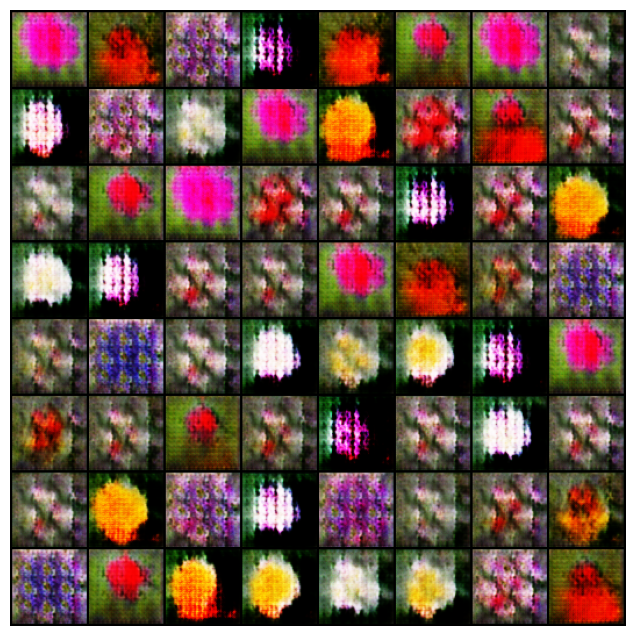

In [16]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)]
       for i in img_list]

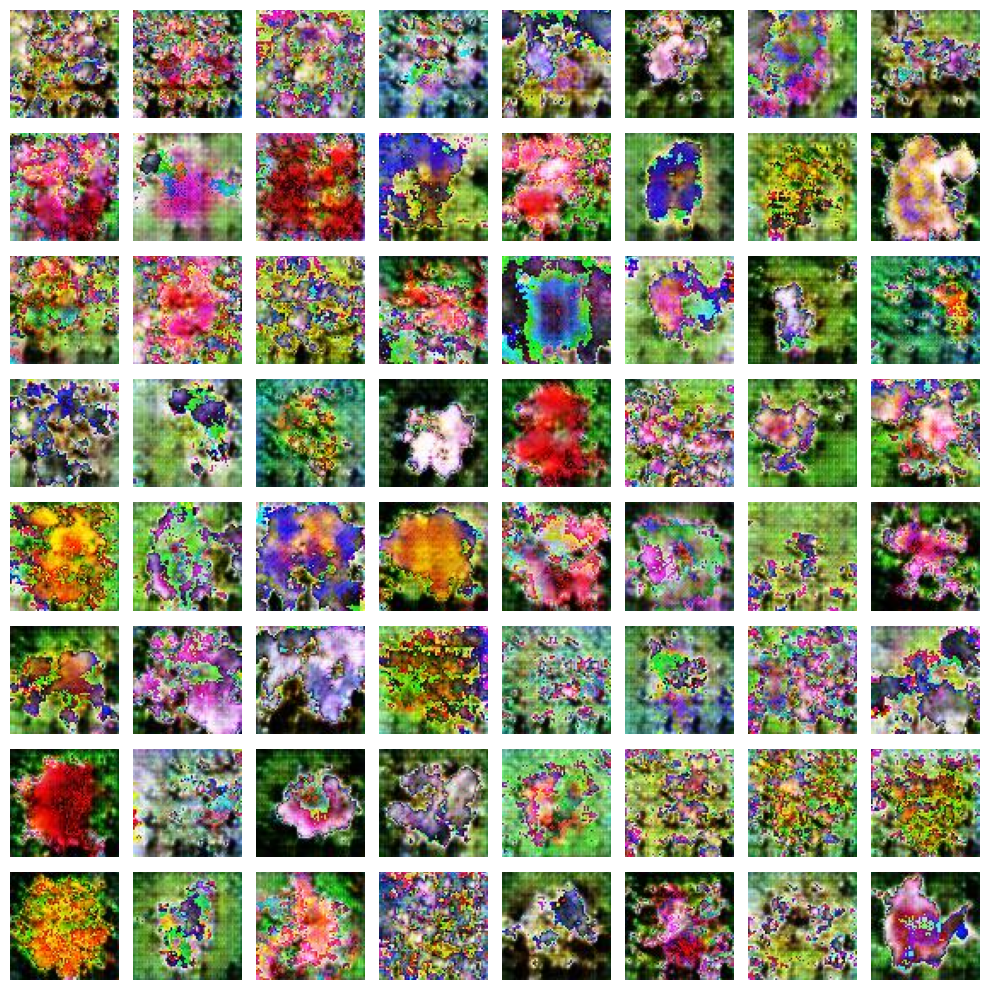

In [17]:
grid_size = 8  # 8x8 grid
num_images = grid_size * grid_size

# Read all image files in the folder
image_files = sorted([os.path.join(generated_images_folder, f)
                      for f in os.listdir(generated_images_folder)
                      if f.endswith(('.png', '.jpg', '.jpeg'))])

# Ensure we have enough images
if len(image_files) < num_images:
    raise ValueError(
        f"Not enough images in {generated_images_folder}. Found {len(image_files)} images, need {num_images}.")

# Load images and resize to the same dimensions
images = [Image.open(image_file).resize((64, 64))
          for image_file in image_files[:num_images]]

# Convert images to a grid
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()